In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(engine, reflect=True)
# reflect the tables

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)

# Exploratory Climate Analysis

In [10]:
from datetime import datetime

In [11]:
from sqlalchemy import and_

Latest date : 2017-08-23
Date year ago : 2016-08-23
2230


<Figure size 1440x720 with 0 Axes>

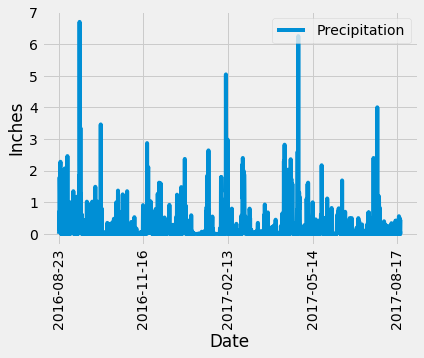

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results


dates = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
latest_date=dates.date
print(f"Latest date : {latest_date}")



# Calculate the date 1 year ago from the last data point in the database
year_ago=dt.datetime.strptime(latest_date,"%Y-%m-%d").date()-dt.timedelta(days=365)
print(f"Date year ago : {year_ago}")

# Perform a query to retrieve the data and precipitation scores
data=session.query(Measurement.date,Measurement.prcp).filter(and_(Measurement.date<=latest_date,Measurement.date>=year_ago)).all()
dict={}
list_date=[]
list_prcp=[]
for d in data:
    list_date.append(d.date)
    list_prcp.append(d.prcp)
    #print(d)
print(len(data))
dict["Date"]=list_date
dict["Precipitation"]=list_prcp
dict

# Save the query results as a Pandas DataFrame and set the index to the date column
data_df=pd.DataFrame(dict)
data_df=data_df.dropna()
data_df.head()

# Sort the dataframe by date
data_df_copy=data_df.set_index("Date")
data_df_copy.sort_index(inplace=True)
data_df_copy.tail(10)


# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(20,10))
data_df_copy.plot(label="Precipitation")
plt.xticks(rotation=90)
plt.xlabel("Date")
plt.ylabel("Inches")
plt.legend(loc="upper right")
plt.show()

In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
data_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [14]:
# Design a query to show how many stations are available in this dataset?
stations=session.query(Station.name).count()
print(f"Number of stations : {stations}")

Number of stations : 9


In [15]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
stations_count=session.query(Measurement.station, Station.name, func.count(Measurement.station))\
.join(Station , Measurement.station== Station.station).group_by(Measurement.station)\
.order_by(func.count(Measurement.station).desc())

#Most active station
(id, name, count)=np.ravel(stations_count[0])
print(f"The most active station is: {name} with id: {id} and count: {count}")


    
    
#Reading the query directly in pandas Dataaframe   
stations_count_1=stations_count.statement
station_count_df = pd.read_sql_query(stations_count_1, session.bind)
station_count_df.rename(columns={"station":"Station id","name":"Station name","count_1":"Count"}, inplace=True)
station_count_df.head(10)


The most active station is: WAIHEE 837.5, HI US with id: USC00519281 and count: 2772


,Station id,Station name,Count
0,USC00519281,"WAIHEE 837.5, HI US",2772
1,USC00519397,"WAIKIKI 717.2, HI US",2724
2,USC00513117,"KANEOHE 838.1, HI US",2709
3,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",2669
4,USC00516128,"MANOA LYON ARBO 785.2, HI US",2612
5,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",2202
6,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",1979
7,USC00517948,"PEARL CITY, HI US",1372
8,USC00518838,"UPPER WAHIAWA 874.3, HI US",511


In [16]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
stats_station = session.query(Measurement.station,func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs))\
.filter(Measurement.station == id).all()
stats_station
(id, min_temp, max_temp, avg_temp)=np.ravel(stats_station)
print(f"For the most active station: {name} with id: {id} the temperature recorded is Lowest: {min_temp}, Highest: {max_temp} and Average: {avg_temp}")


For the most active station: WAIHEE 837.5, HI US with id: USC00519281 the temperature recorded is Lowest: 54.0, Highest: 85.0 and Average: 71.66378066378067


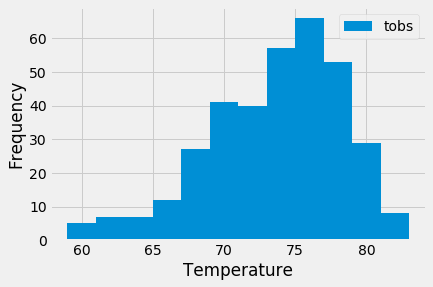

In [17]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
#Querying temperature data for most active station in last 12 months  
data_temp_obs=session.query(Measurement.tobs).filter(and_(Measurement.date<=latest_date,Measurement.date>=year_ago)).filter(Measurement.station==id).all()

list_temp_obs=[]
for d in data_temp_obs:
    list_temp_obs.append(d.tobs)



plt.hist(list_temp_obs,bins=12,label="tobs")
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.legend(loc="best")
plt.show()

## Bonus Challenge Assignment

In [18]:
from scipy import stats
from scipy import mean

#Tempertaure Analysis 1
june=session.query(Measurement.tobs).filter(func.strftime("%m",Measurement.date)=="06")
j_tobs=[]
for j in june:
    j_tobs.append(j.tobs)

print(f"Average temperature in June across all stations: {mean(j_tobs)}")

    
december=session.query(Measurement.tobs).filter(func.strftime("%m",Measurement.date)=="12")
d_tobs=[]
for d in december:
    d_tobs.append(d.tobs)

print(f"Average temperature in December across all stations: {mean(d_tobs)}")    
   
####Since the test subject is same i.e the temperature so we use paired t-test
stats.ttest_ind(j_tobs, d_tobs)
#Since p value is less than 0.05 so reject Null hypothesis. i.e there is a statistical difference in the avg temp of june and december.

Average temperature in June across all stations: 74.94411764705882
Average temperature in December across all stations: 71.04152933421226


Ttest_indResult(statistic=31.60372399000329, pvalue=3.9025129038616655e-191)

In [19]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [20]:
#Vacation Start date
current_vs="2018-05-31"
vac_sd=dt.datetime.strptime(current_vs,"%Y-%m-%d").date()-dt.timedelta(days=365)

#Vacation End date
current_ve="2018-06-06"
vac_ed=dt.datetime.strptime(current_ve,"%Y-%m-%d").date()-dt.timedelta(days=365)
#print(vac_sd)
#print(vac_ed)
print(calc_temps(vac_sd,vac_ed))

[(74.0, 77.81395348837209, 81.0)]


In [21]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

(min, avg, max)=np.ravel(calc_temps(vac_sd,vac_ed))
print(calc_temps(vac_sd,vac_ed))

[(74.0, 77.81395348837209, 81.0)]


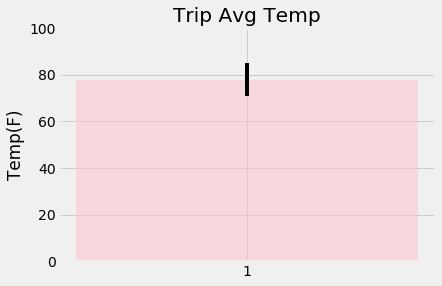

In [22]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

plt.bar(1,avg,width=0.10,yerr=max-min,color="pink", alpha=0.5)
plt.xticks(ticks=[1])
plt.title("Trip Avg Temp")
plt.ylim(0,100)
plt.ylabel("Temp(F)")
plt.show()

In [23]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

rainfall=session.query(Station.station,Station.name, Station.latitude, Station.longitude,\
                       Station.elevation, func.sum(Measurement.prcp)).join(Station, Measurement.station==Station.station)\
                        .filter(and_(Measurement.date>=vac_sd, Measurement.date<=vac_ed)).filter(func.strftime("%Y", Measurement.date)=="2017")\
                        .filter(Measurement.prcp.isnot(None)).group_by(Measurement.station).order_by(func.sum(Measurement.prcp).desc())
for r in rainfall:
    print(r)

('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.84)
('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.6000000000000001)
('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.5800000000000001)
('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.38)
('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.15)
('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.04)


In [24]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [25]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
# Use the start and end date to create a range of dates
date_range=pd.date_range(start=current_vs, end=current_ve)

# Stip off the year and save a list of %m-%d strings
trip_d=[]
trip_dates=[]
for date in date_range:
    trip_dates.append(date)
    trip_d.append(date.strftime("%m-%d"))
    
trip_d    
# Loop through the list of %m-%d strings and calculate the normals for each date
normals=[]
for d in trip_d:
    normals.append(daily_normals(d))
normals


[[(68.0, 74.4, 81.0)],
 [(64.0, 74.6140350877193, 81.0)],
 [(65.0, 74.4, 81.0)],
 [(65.0, 74.03448275862068, 80.0)],
 [(65.0, 73.81818181818181, 81.0)],
 [(68.0, 74.85454545454546, 81.0)],
 [(70.0, 75.17543859649123, 80.0)]]

In [26]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
Min=[]
Avg=[]
Max=[]

for n in normals:
    (min,avg,max)=np.ravel(n)
    Min.append(min)
    Avg.append(avg)
    Max.append(max)
    
    
trip_normaldf=pd.DataFrame({"Date":trip_dates,"Min Temp":Min,"Avg Temp": Avg,"Max Temp": Max})
trip_normaldf.set_index("Date",inplace=True)
trip_normaldf.head(7)

,Min Temp,Avg Temp,Max Temp
Date,,,
2018-05-31,68.0,74.400000,81.0
2018-06-01,64.0,74.614035,81.0
2018-06-02,65.0,74.400000,81.0
2018-06-03,65.0,74.034483,80.0
2018-06-04,65.0,73.818182,81.0
2018-06-05,68.0,74.854545,81.0
2018-06-06,70.0,75.175439,80.0


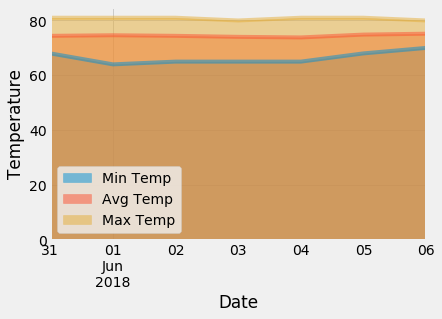

In [27]:
# Plot the daily normals as an area plot with `stacked=False`
trip_normaldf.plot.area(stacked=False)
plt.xlabel("Date")
plt.ylabel("Temperature")
plt.show()